In [1]:
#pip install num2words
!pip install unidecode

     |████████████████████████████████| 245kB 9.3MB/s 


In [2]:
import os
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from bs4 import BeautifulSoup
#from lxml import etree
from collections import defaultdict, Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics, cluster, preprocessing
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import seaborn as sns
%matplotlib inline
from sklearn import manifold, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble \
import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
import timeit
import itertools
import unidecode
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive') 
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks")
import os 
os.chdir('/content/drive/My Drive/Colab Notebooks/P6_Catégorisez automatiquement des questions')

Mounted at /content/drive


# Constantes et fonctions

In [4]:
SEP = {'Title' : ' ', 'Body' : ' ', 'Tags' : '><'}
TOP = 50

def conv_html(col):
    """
    Fonction de convertion de html en chaine standard
    """

    html = BeautifulSoup(col, 'html.parser')
    # Delete url strings
    for t in html.find_all('a'):
        t.replace_with('')
    # Delete code blocks
    for t in html.find_all('pre'):
        t.replace_with('')
    
    return html.get_text(' ', strip=True)

def clean_field(col, tknzr, sw, lmtzr, stmr):
    """
    Fonction de tokenisation du contenu dont regex \w+, 
    suppression des stopwords, lemmatisation et racinisation
    """

    temp = tknzr.tokenize(unidecode.unidecode(col).lower())
    return ' '.join(stmr.stem(lmtzr.lemmatize(w, get_wordnet_pos(w))) \
                    for w in temp if w not in sw and not w.isdigit())

def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def recap_cols(df, cols):
    """
    Fonction de dénombrement du contenu des listes des colonnes (cols) de df
    """

    print('='*50, '\nDénombrenent des mots')
    
    for col in cols:
        #liste = list(itertools.chain.from_iterable(df[col].values))
        freq[col] = Counter(' '.join(df[col].values).split()).most_common()
        print('\t{:6s} : {:>7d} dont {:>6d} distincts'.\
                format(col, sum(dict(freq[col]).values()), len(freq[col])))
    print('='*50)
        
    return freq

def tag_question(title, body, lbl_t, lbl_b, mod):
    """
    Prediction function of stackexchange tags from a query passed as parameter
    """

    title = clean_field(title)
    body = clean_field(body)

    tfidf_t = lbl_t.transform(title)
    tfidf_b = lbl_t.transform(title)

    X_train = tfidf_t * 1/3 + tfidf_b * 2/3

    return mod.predict(std_scale.transform(X_train))

# Chargement

In [5]:
with open('OC_DS_P6_backup.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    train = unpickler.load()

# TF-IDF
Je crée un dictionnaire pour les vecteurs TFIDF pour les appeler dans la fonction finale

In [6]:
dict_tfidf = defaultdict(dict)
sample = 5000
sample_df = train.sample(sample)

for col in ['Title', 'Body']:
    X = train[col][:sample]
    dict_tfidf[col]['vector'] = TfidfVectorizer(token_pattern='[a-z0-9_#]+', \
                                                min_df=15).fit(X)
    v_tfidf = dict_tfidf[col]['vector'].transform(X)
    cols = dict_tfidf[col]['vector'].get_feature_names()
    dict_tfidf[col]['df'] = pd.DataFrame(v_tfidf.todense().tolist(), \
                                         columns=cols, index=train.index[:sample])
    print(col, ':', dict_tfidf[col]['df'].shape)
    print(cols)

Title : (5000, 394)
['access', 'action', 'activ', 'add', 'address', 'ajax', 'algorithm', 'allow', 'altern', 'anoth', 'apach', 'api', 'app', 'append', 'applic', 'argument', 'array', 'asp', 'assembl', 'assign', 'attribut', 'avoid', 'back', 'background', 'bad', 'bar', 'base', 'best', 'bind', 'bit', 'block', 'branch', 'browser', 'build', 'button', 'byte', 'c', 'c#', 'cach', 'cakephp', 'calcul', 'call', 'case', 'caus', 'chang', 'char', 'charact', 'check', 'child', 'class', 'click', 'clickonc', 'client', 'code', 'collect', 'color', 'column', 'com', 'combin', 'command', 'commit', 'compar', 'compil', 'condit', 'config', 'configur', 'connect', 'constructor', 'contain', 'content', 'control', 'convert', 'copi', 'correct', 'cs', 'current', 'custom', 'data', 'databas', 'date', 'datetim', 'debug', 'default', 'defin', 'delet', 'delphi', 'depend', 'deploy', 'design', 'detect', 'determin', 'develop', 'differ', 'directori', 'disabl', 'display', 'div', 'django', 'dll', 'document', 'doubl', 'download', 'd

In [7]:
'c#' in dict_tfidf['Title']['vector'].get_feature_names()

True

## PCA

In [ ]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='\w+',  
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(train.Title)
data_vectorized.shape

(50000, 2270)

In [9]:
pca = decomposition.PCA(n_components=2)

X = dict_tfidf['Title']['df']

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

X_trans = pca.fit_transform(X_scaled)

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0.00555203 0.00528072] 0.010832748492658773


best clustering =  400


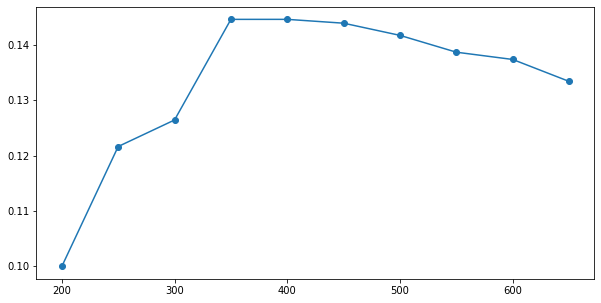

In [14]:
fig = plt.figure(figsize=(10, 5))
# Iteration de clustering kmeans avec des nb de clusters différents
silhouettes = []
cluster_range = range(200, 700, 50)
for n in cluster_range:
    myclust = cluster.KMeans(n_clusters=n, random_state=1)
    myclust.fit(X_scaled)
    silhouettes.append(metrics.silhouette_score(X_scaled, myclust.labels_))

plt.plot(cluster_range, silhouettes, marker='o')

best_cluster = cluster_range[np.argmax(silhouettes)]
print('best clustering = ', best_cluster)

## Clustering

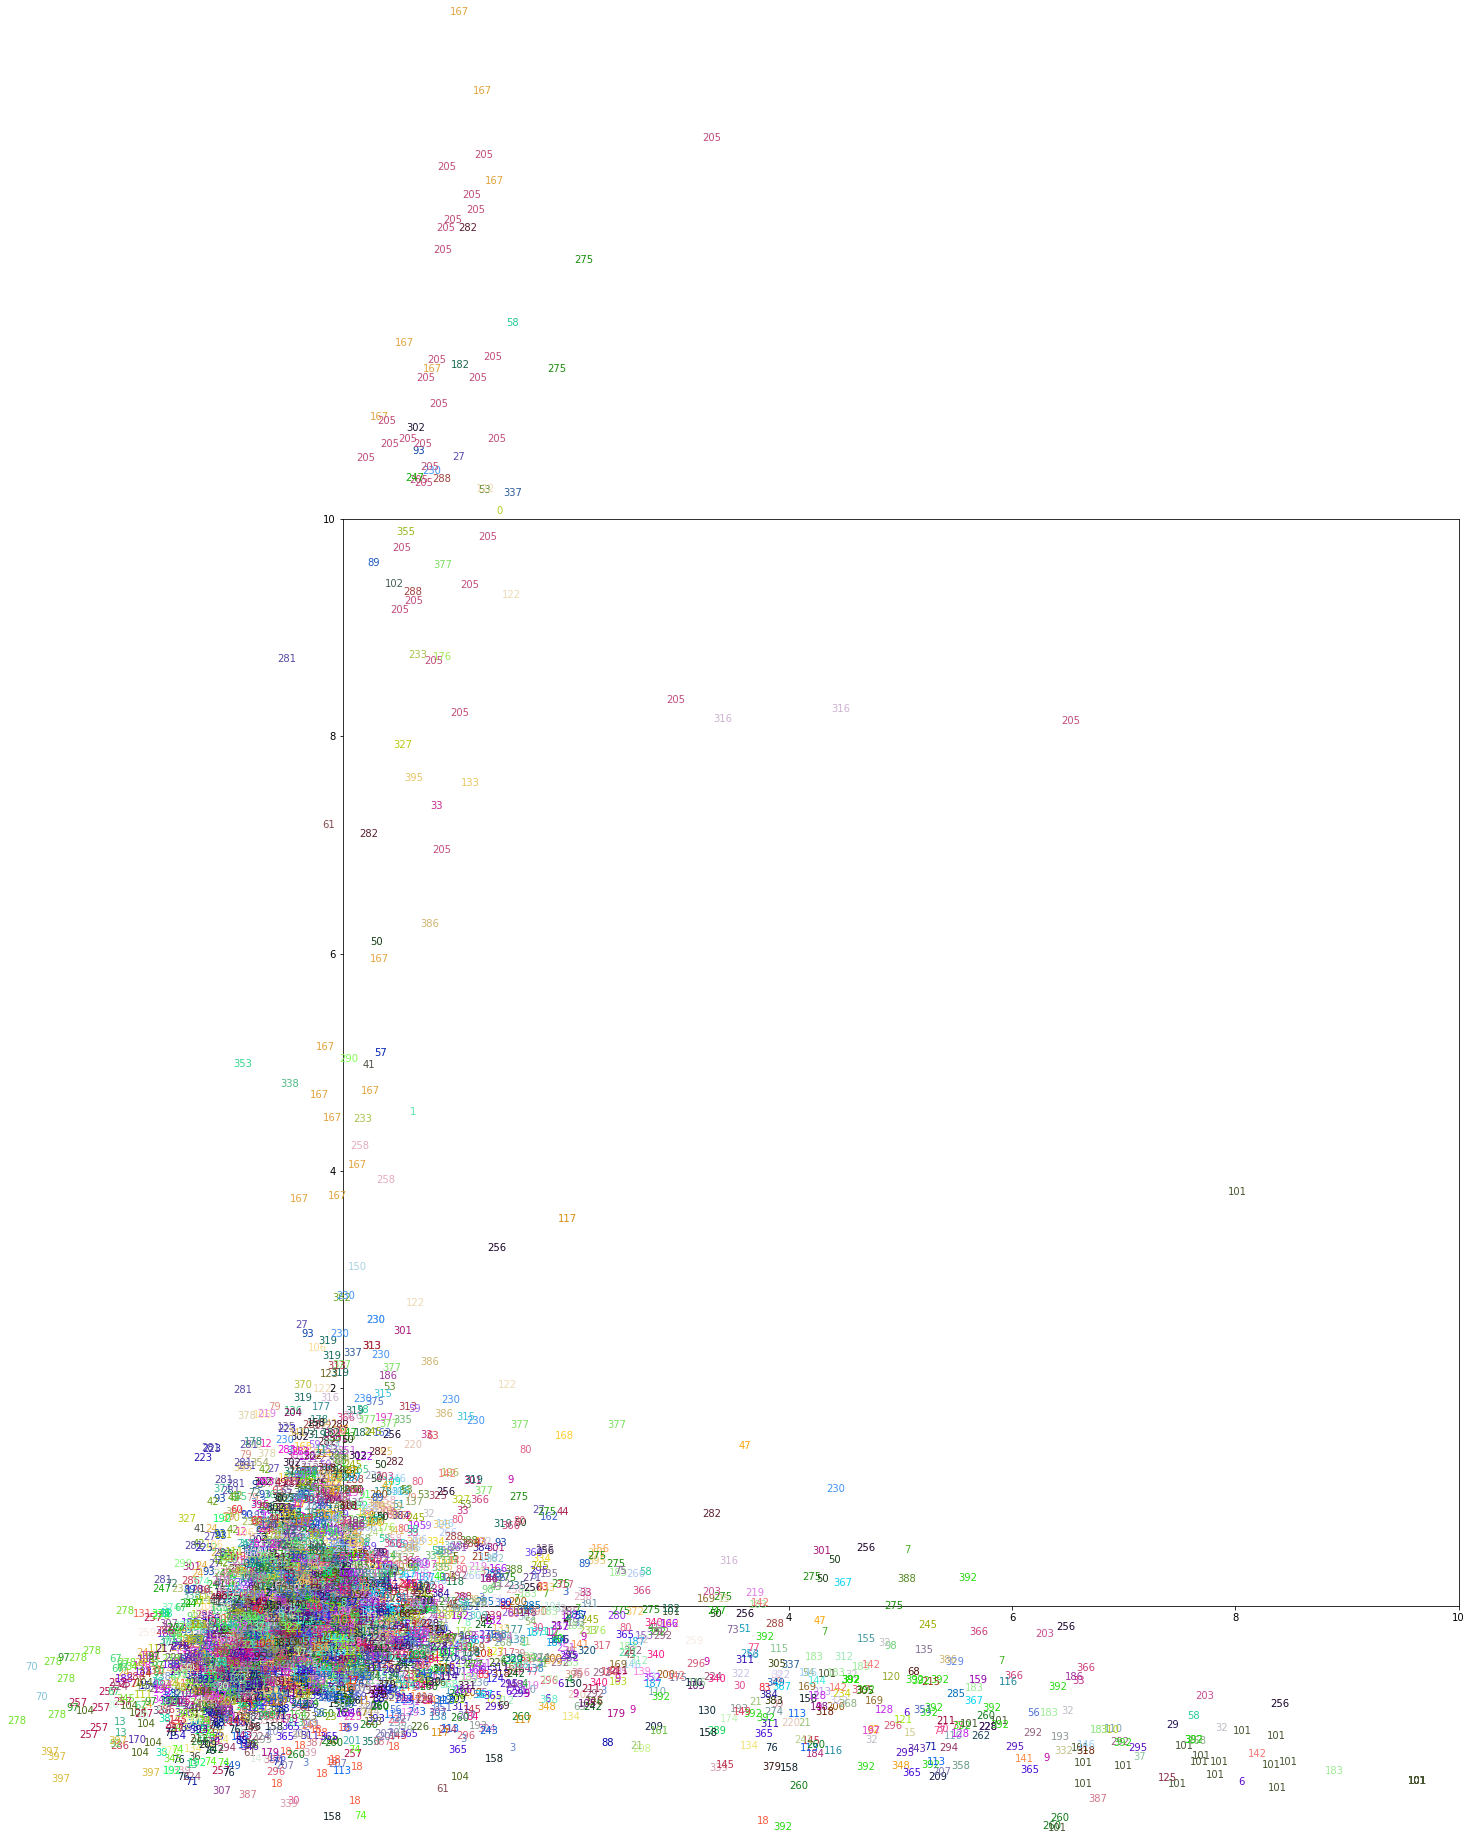

Silhouette Coefficient: 0.093


In [15]:
nb_clusters = 400
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Puis on applique tSNE aux données scalées :
#tsne = manifold.TSNE(n_components=2, init='pca')
#X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise 
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], 
             myclust.labels_[i], color=color[myclust.labels_[i]] ) 
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [16]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = dict_tfidf['Title']['df'].assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399
0,11,17,10,273,13,13,15,15,26,12,13,13,15,15,10,6,16,8,15,14,14,13,17,14,16,13,8,14,14,13,16,12,15,14,10,13,2,19,15,16,...,14,2,4,1,15,15,17,17,3,13,16,2,11,2,13,1,13,11,3,12,1,10,3,14,12,3,13,16,11,1,12,17,35,16,6,16,10,5,3,1


# Classification supervisée

In [ ]:
DICT_CLF = {'knn': {'name': 'k-Nearest Neighbors',
                     'clf': KNeighborsClassifier(),
                     'params': {'n_neighbors': np.arange(1,50,1)}},
            'svm': {'name': 'Support Vector Machine',
                     'clf': LinearSVC(dual=False, multi_class='ovr') ,
                     'params': {'C': np.logspace(-3, 3, 7),
                                'loss': ['hinge','squared_hinge'],
                                'penalty': ['l1', 'l2']}},
            'rfc': {'name': 'Random Forrest',
                     'clf': RandomForestClassifier(),
                     'params': {'criterion': ['entropy', 'gini'],
                                'n_estimators': [20, 40, 60, 80, 100],
                                'max_features':['sqrt', 'log2']}},
            'adc': {'name': 'AdaBoost',
                     'clf': AdaBoostClassifier(),
                     'params': {'n_estimators': \
                                [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}},
            'gbc': {'name': 'Gradient Boosting',
                     'clf': GradientBoostingClassifier(),
                     'params': {'n_estimators': \
                                [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}}
            }

In [ ]:
dict_precision = {}

for k, v in DICT_CLF.items():
    print('{}\n{}\n{}'.format('='*30, v['name'], '-'*30))
    dict_precision[v['name']] = {}

    clf = v['clf']
    gs = GridSearchCV(clf, v['params'], cv=5, scoring = 'accuracy',n_jobs=-1)
    gs.fit(X_train_scaled, y_train)
    print("Best params:", gs.best_params_, '\n')
    dict_precision[v['name']]['clf'] = gs

    y_pred = gs.predict(X_test_scaled)
    precision = 100*metrics.accuracy_score(y_test, y_pred).round(2)
    dict_precision[v['name']]['precision'] = precision
    print("Precision: {:.2f} % \n".format(precision))

## Title

In [ ]:
y = train.Tags_lbl[:sample]

for col in ['Title', 'Body']:
    print('='*50)
    X = dict_tfidf[col]['vector'].transform(train.Title[:sample])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    std_scale = preprocessing.StandardScaler(with_mean=False).fit(X_train)
    X_train_scaled = std_scale.transform(X_train)
    X_test_scaled = std_scale.transform(X_test)
    X_train_scaled.shape, X_test_scaled.shape

    gs = RandomForestClassifier()

    start_time = timeit.default_timer()
    print(start_time, '->', end='')

    gs.fit(X_train_scaled, y_train)
    y_pred = gs.predict(X_test_scaled)

    elapsed = timeit.default_timer() - start_time

    accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
    print(col, ": accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

In [ ]:
gs = RandomForestClassifier()

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print(col, "accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

accuracy 1.00% time 104.39s



## Body

In [ ]:
X = dict_tfidf['Body']['df']
y = train.Tags_lbl[:sample]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((3500, 1438), (1500, 1438))

In [ ]:
gs = RandomForestClassifier()

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

## Title + Body

In [ ]:
# Regroupement des df Title et Body
ratio = 1/3
titles = dict_tfidf['Title']['df'][:sample]
bodies = dict_tfidf['Body']['df'][:sample]

X = (ratio * titles).add((1 - ratio) * bodies, fill_value=True).fillna(0)
y = train.Tags_lbl[:sample]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((3500, 1440), (1500, 1440))

In [ ]:
gs = RandomForestClassifier()

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

## Focus Body

In [ ]:
tfidf_Body_v = tfidf_vectorizer.fit_transform(train_1T['Body'])
feature_names = tfidf_vectorizer.get_feature_names()

tfidf_Body = pd.DataFrame(tfidf_Body_v.todense().tolist(), columns=feature_names, index=train_1T.index)
tfidf_Body.head()

,a,ab,abandon,abbrevi,abbyy,abc,abcd,abcdefghi,abil,abl,abnorm,abort,aboutm,abovement,absenc,absolut,abstract,absurd,abt,abus,ac,academ,academi,acccess,accdb,accent,accept,acces,access,accessor,accid,accident,accommod,accompani,accomplish,accord,accordingli,account,accountcontrol,accountmanag,...,xxxxxxxxxx,y,ya,yaaq,yahoo,yahtze,yaml,yank,yay,ye,yeah,year,yearli,yellow,yesterday,yet,yield,yike,yolk,york,young,youtub,yu,yy,zc,zed,zehut,zeppelin,zero,zf,zi,zijab,zip,ziparch,zone,zoom,zope,zqw,zsh,zubair
1023055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2177008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
630434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tfidf_Title[tfidf_Title.index == 2177008].sum().reset_index().sort_values(by=0, ascending=False)

,index,0
1311,mean,0.750079
1904,rubi,0.661349
1695,pro,0.000000
1688,primit,0.000000
1689,princip,0.000000
...,...,...
847,fork,0.000000
848,forloop,0.000000
849,form,0.000000
850,format,0.000000


In [ ]:
train_1T.head()

,Title,Body,Tags,nTags
1023055,sort current point end file gvim,follow command mode gvim result star littl som...,vim,1
2177008,mean rubi,mean rubi,ruby,1
368947,javascript error thrown ajaxtoolkit net machin,button save asynchron ajaxtoolkit c net error ...,.net,1
488240,chang checkbox javascript,seri checkbox html page check checkbox base co...,javascript,1
630434,jqueri overwrit click event within click,function call attach click event link locat to...,jquery,1


PCA

In [ ]:
pca = decomposition.PCA(n_components=2)

X = tfidf_Body.values

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

X_trans = pca.fit_transform(X_scaled)

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0. 0.] 0.0036313742918188284


Clustering

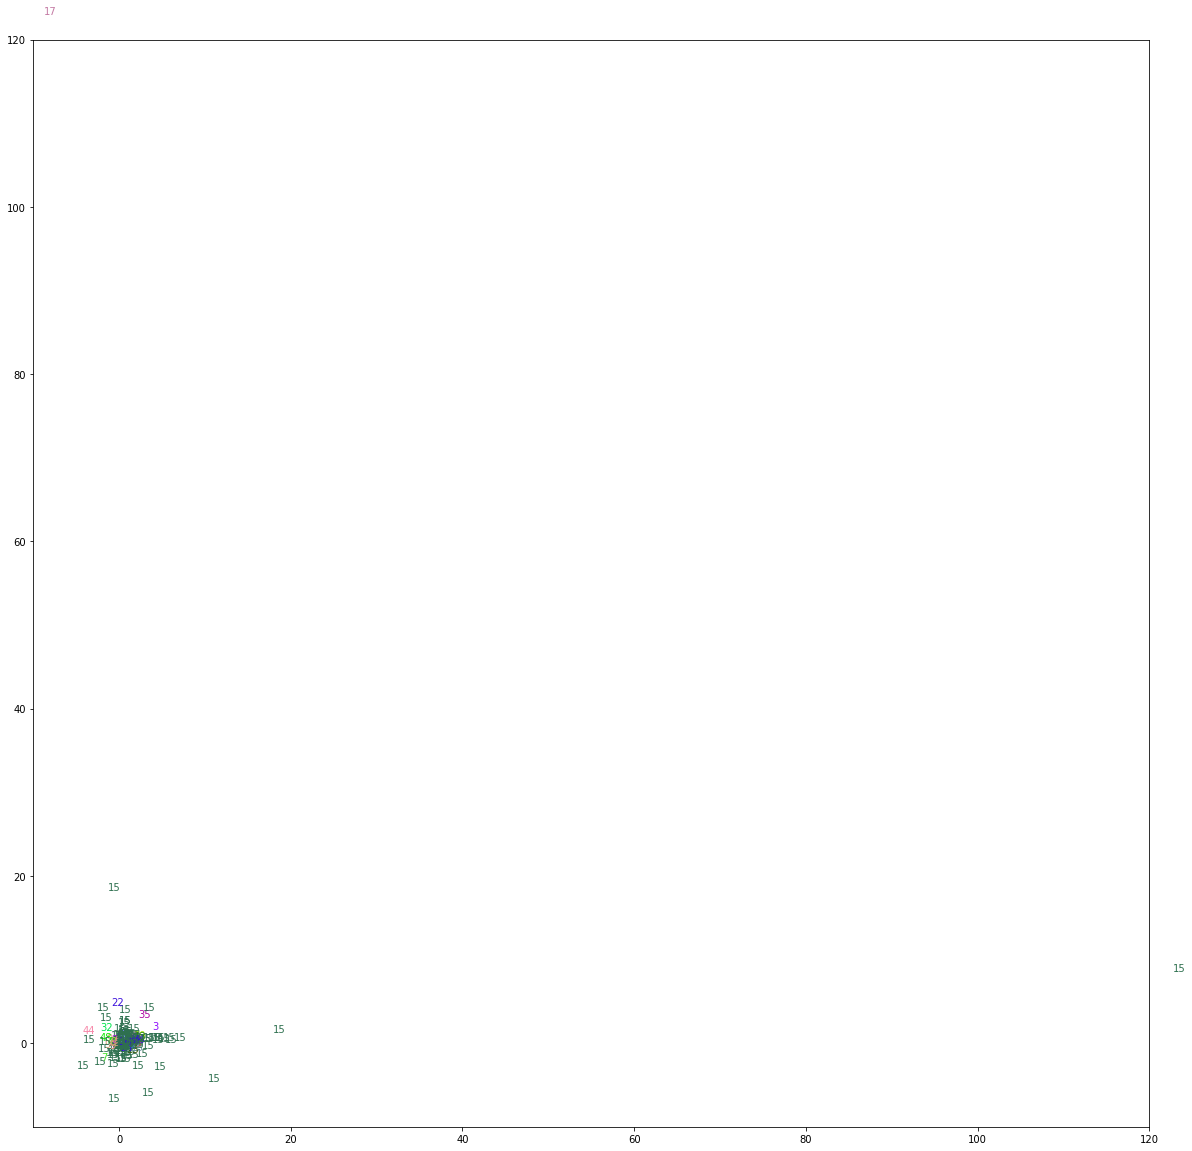

Silhouette Coefficient: -0.041


In [ ]:
nb_clusters = 50
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Puis on applique tSNE aux données scalées :
#tsne = manifold.TSNE(n_components=2, init='pca')
#X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise, selon la méthode donnée dans le coup de pouce :
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], 
             myclust.labels_[i], color=color[myclust.labels_[i]] ) 
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [ ]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = tfidf_Title.assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,3,10,43,1,1,1,1,1,1,38,12,1,1,1,8,2914,1,1,1,1,1,1,1,1,329,1,1,1,1,1,1,1,1,1,64,1,1,1,1,1,1,1,1,1,1,1,1,1,20,1


Classification supervisée

In [ ]:
lbl = LabelEncoder()

lbl_tag = lbl.fit_transform(train_1T.Tags)

X_train, X_test, y_train, y_test = train_test_split(tfidf_Body, lbl_tag, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((2436, 7045), (1045, 7045))

accuracy 64.00% time 3.30s

Confusion matrix, without normalization


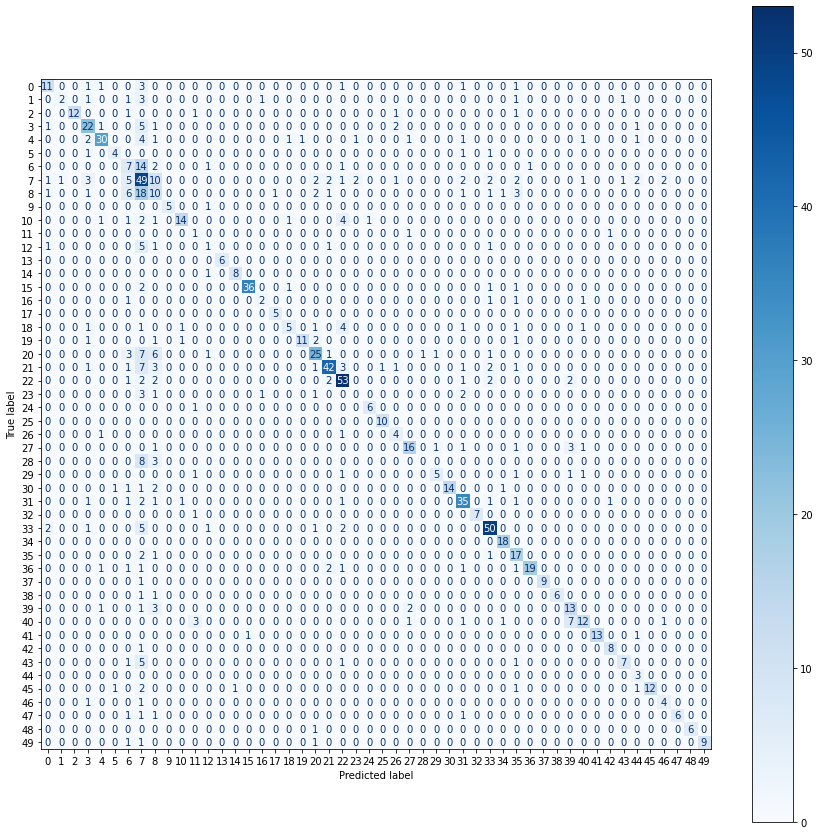

Normalized confusion matrix


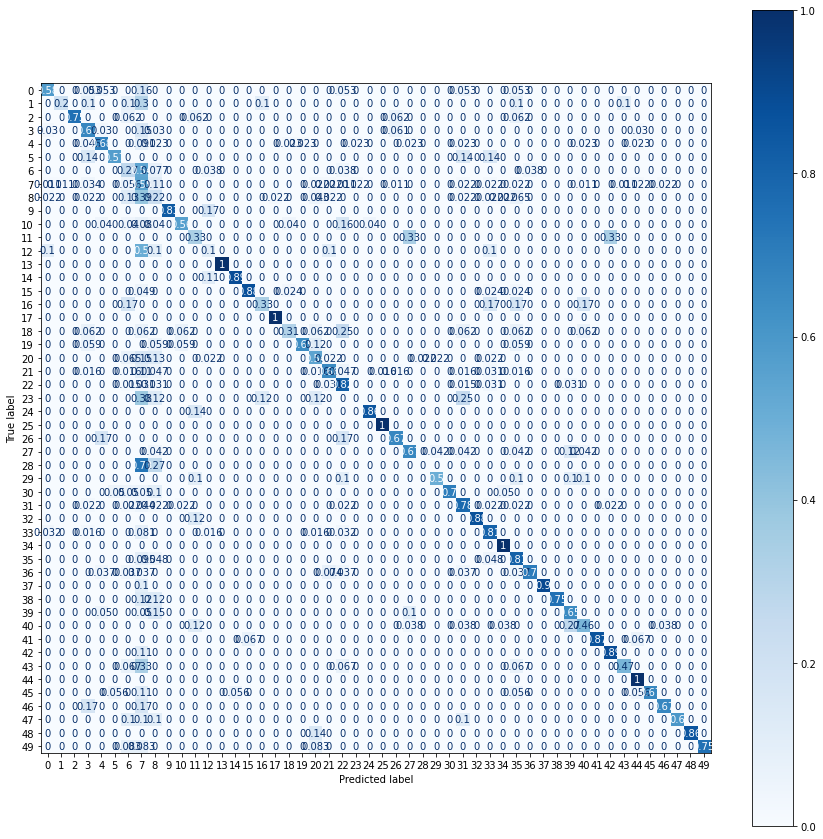

In [ ]:
gs = RandomForestClassifier()

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

np.set_printoptions(precision=2)

#plt.figure(figsize=(20, 20))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
cpt = 1 
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(15, 15))
    metrics.plot_confusion_matrix(gs, X_test_scaled, y_test, \
                                  # display_labels=class_names, 
                                  cmap=plt.cm.Blues, \
                                  normalize=normalize, ax=ax)
    #ax_.set_title(title)

    print(title)
    #print(disp.confusion_matrix)
    plt.show()
    cpt += 1 

# TF-IDF new

## Focus Title

In [ ]:
tfidf_Title_v = tfidf_vectorizer.fit_transform(train['Title'])
feature_names = tfidf_vectorizer.get_feature_names()

tfidf_Title = pd.DataFrame(tfidf_Title_v.todense().tolist(), columns=feature_names, index=train.index)
tfidf_Title.head()

NameError: ignored

In [ ]:
tfidf_Title[tfidf_Title.index == 2177008].sum().reset_index().sort_values(by=0, ascending=False)

,index,0
1197,mean,0.760171
1736,rubi,0.649723
1545,produc,0.000000
1539,privileg,0.000000
1540,pro,0.000000
...,...,...
772,forbidden,0.000000
773,forc,0.000000
774,foreach,0.000000
775,foreign,0.000000


In [ ]:
train_1T.head()

,Title,Body,Tags,nTags
2177008,mean rubi,mean rubi,ruby,1
368947,javascript error thrown ajaxtoolkit net machin,button save asynchron ajaxtoolkit c net error ...,.net,1
488240,chang checkbox javascript,seri checkbox html page check checkbox base co...,javascript,1
630434,jqueri overwrit click event within click,function call attach click event link locat to...,jquery,1
1087251,simpl html construct asp net,simpl question think put tag asp net app ask m...,asp.net,1


### PCA

In [ ]:
pca = decomposition.PCA(n_components=2)

X = tfidf_Title.values

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

X_trans = pca.fit_transform(X_scaled)

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0.00215878 0.00198559] 0.004144369675533617


### Clustering

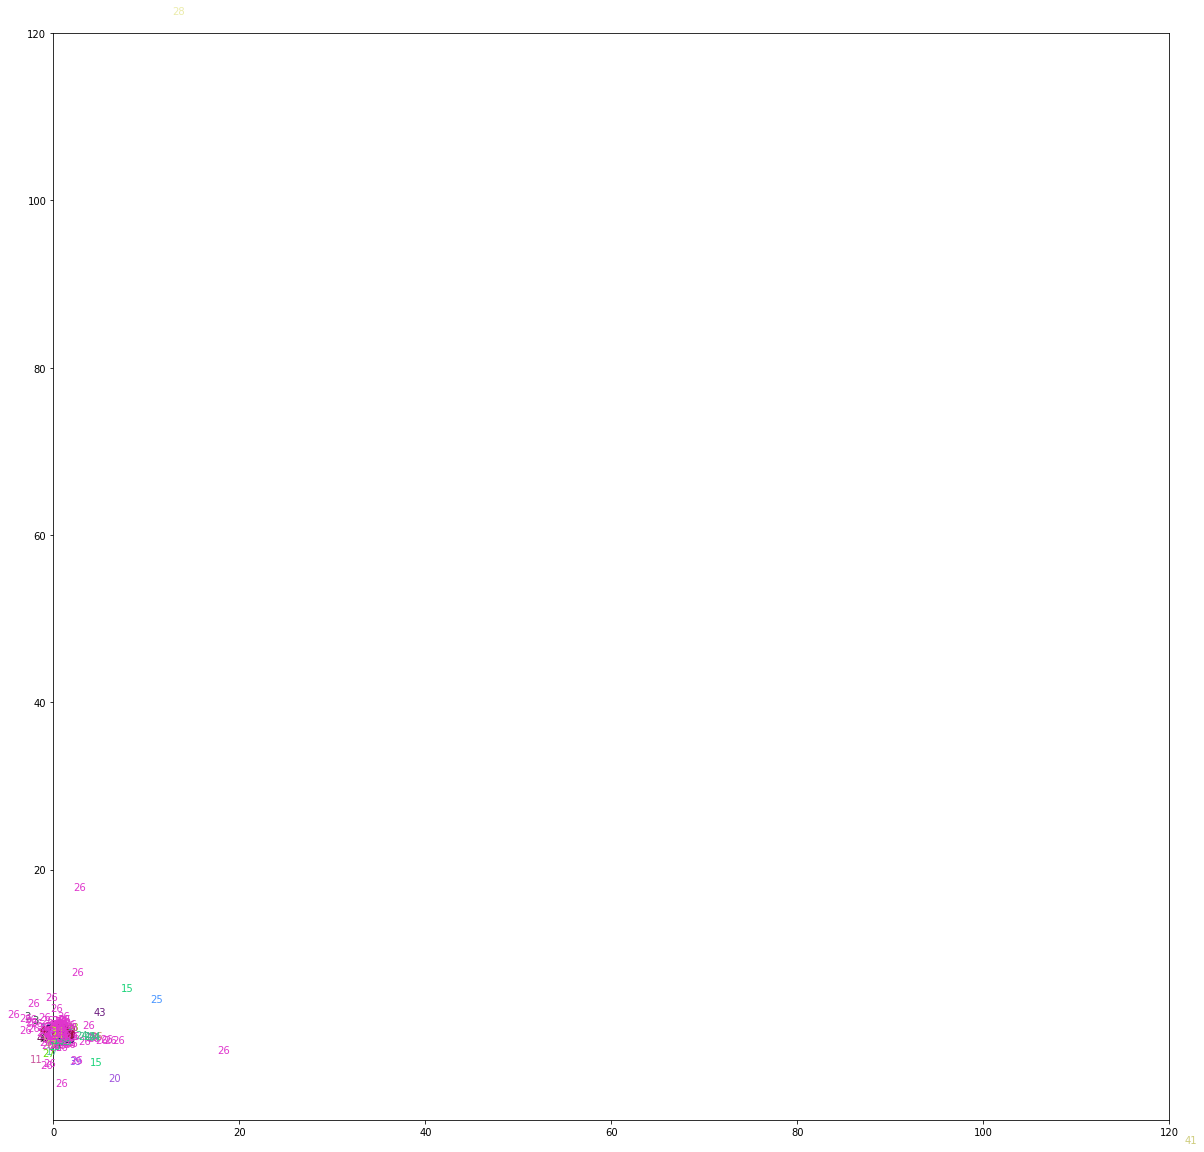

Silhouette Coefficient: -0.039


In [ ]:
nb_clusters = 50
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Puis on applique tSNE aux données scalées :
#tsne = manifold.TSNE(n_components=2, init='pca')
#X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise 
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], 
             myclust.labels_[i], color=color[myclust.labels_[i]] ) 
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [ ]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = tfidf_Title.assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1,7,1,51,1,1,1,1,1,31,1,47,1,45,20,163,1,1,1,1,1,1,7,45,6,1,2886,1,1,7,1,1,1,1,1,1,1,1,1,1,88,1,1,1,2,1,41,1,1,1


### Classification supervisée

In [ ]:
lbl = LabelEncoder()

lbl_tag = lbl.fit_transform(train_1T.Tags)

X_train, X_test, y_train, y_test = train_test_split(tfidf_Title, lbl_tag, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((2436, 2538), (1045, 2538))

accuracy 65.00% time 3.14s

Confusion matrix, without normalization


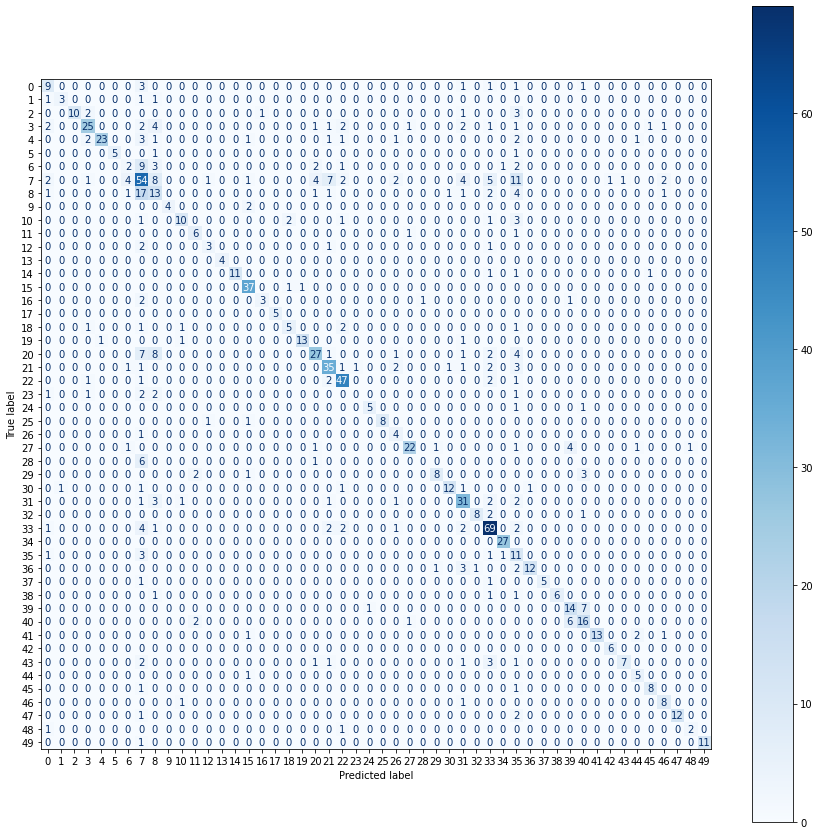

Normalized confusion matrix


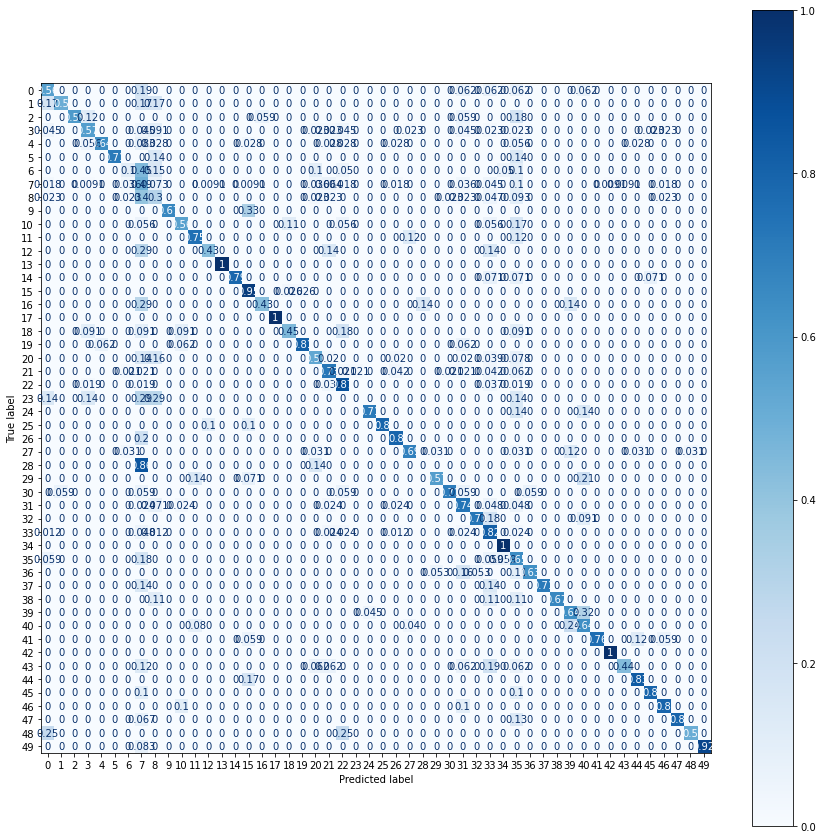

In [ ]:
gs = RandomForestClassifier()

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

np.set_printoptions(precision=2)

#plt.figure(figsize=(20, 20))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
cpt = 1 
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(15, 15))
    metrics.plot_confusion_matrix(gs, X_test_scaled, y_test, \
                                  # display_labels=class_names, 
                                  cmap=plt.cm.Blues, \
                                  normalize=normalize, ax=ax)
    #ax_.set_title(title)

    print(title)
    #print(disp.confusion_matrix)
    plt.show()
    cpt += 1 

## Focus Body

In [ ]:
from unidecode import unidecode

In [ ]:
train_1T['Body'] = train_1T['Body'].apply(unidecode)

In [ ]:
tfidf_Body_v = tfidf_vectorizer.fit_transform(train_1T['Body'])
feature_names = tfidf_vectorizer.get_feature_names()

tfidf_Body = pd.DataFrame(tfidf_Body_v.todense().tolist(), columns=feature_names, index=train_1T.index)
tfidf_Body.head()

,a,ab,abandon,abbrevi,abbyy,abc,abcd,abcdefghi,abil,abl,abnorm,abort,aboutm,abovement,absenc,absolut,abstract,absurd,abt,abus,ac,academ,academi,acccess,accdb,accent,accept,acces,access,accessor,accid,accident,accommod,accompani,accomplish,accord,accordingli,account,accountcontrol,accountmanag,...,xxxxxxxxxx,y,ya,yaaq,yahoo,yahtze,yaml,yank,yay,ye,yeah,year,yearli,yellow,yesterday,yet,yield,yike,yolk,york,young,youtub,yu,yy,zc,zed,zehut,zeppelin,zero,zf,zi,zijab,zip,ziparch,zone,zoom,zope,zqw,zsh,zubair
1023055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2177008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
630434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
'ß'.isalpha()

True

In [ ]:
tfidf_Title[tfidf_Title.index == 2177008].sum().reset_index().sort_values(by=0, ascending=False)

,index,0
1311,mean,0.750079
1904,rubi,0.661349
1695,pro,0.000000
1688,primit,0.000000
1689,princip,0.000000
...,...,...
847,fork,0.000000
848,forloop,0.000000
849,form,0.000000
850,format,0.000000


In [ ]:
train_1T.head()

,Title,Body,Tags,nTags
1023055,sort current point end file gvim,follow command mode gvim result star littl som...,vim,1
2177008,mean rubi,mean rubi,ruby,1
368947,javascript error thrown ajaxtoolkit net machin,button save asynchron ajaxtoolkit c net error ...,.net,1
488240,chang checkbox javascript,seri checkbox html page check checkbox base co...,javascript,1
630434,jqueri overwrit click event within click,function call attach click event link locat to...,jquery,1


PCA

In [ ]:
pca = decomposition.PCA(n_components=2)

X = tfidf_Body.values

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

X_trans = pca.fit_transform(X_scaled)

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0. 0.] 0.0036313742918188284


Clustering

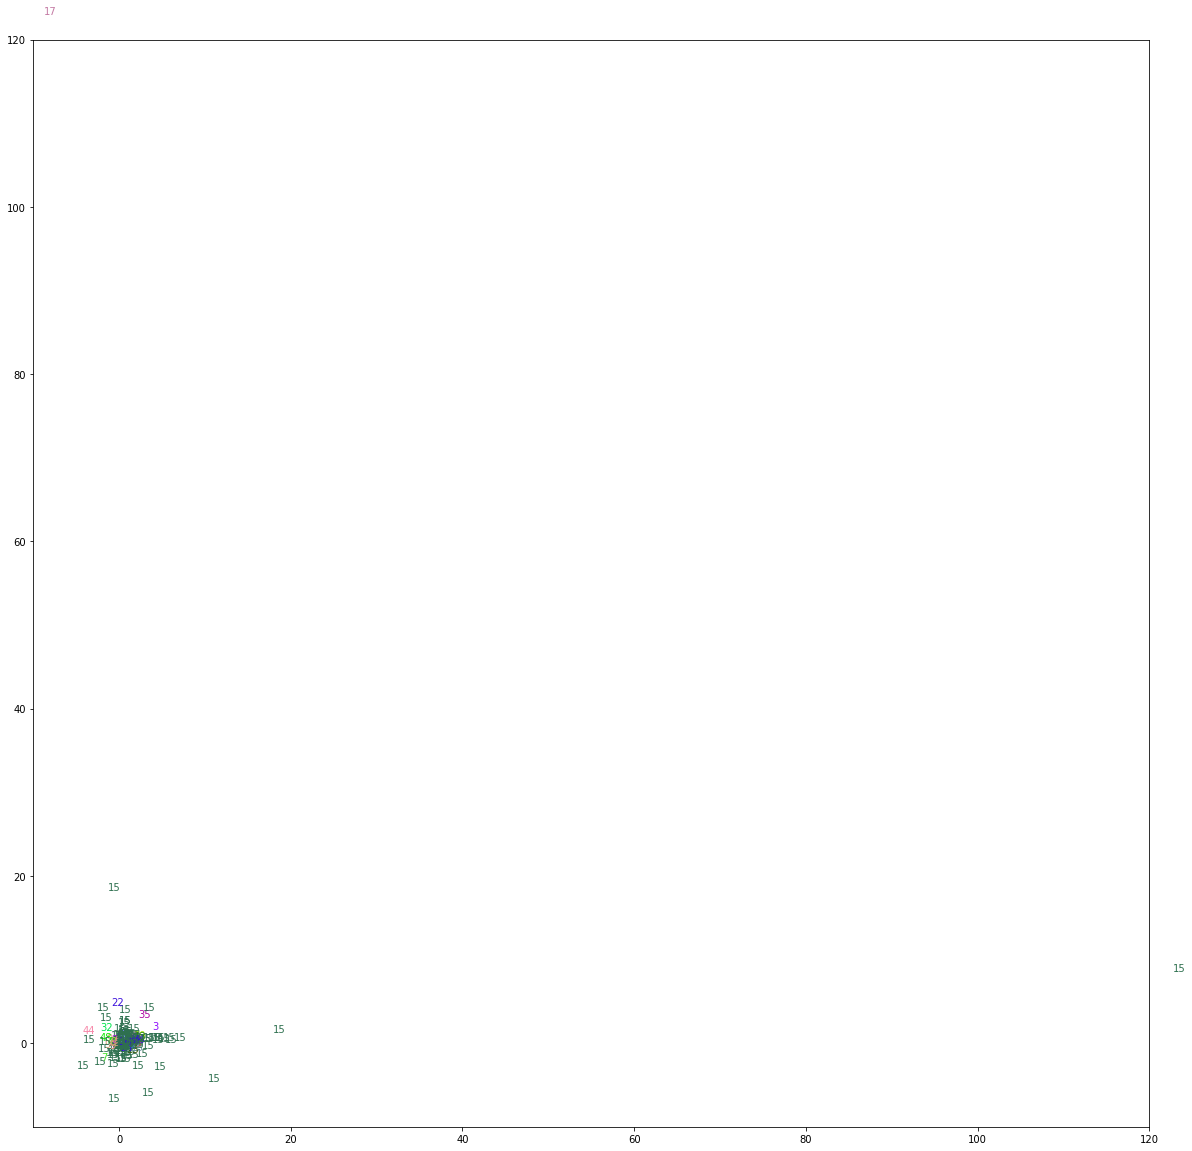

Silhouette Coefficient: -0.041


In [ ]:
nb_clusters = 50
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Puis on applique tSNE aux données scalées :
#tsne = manifold.TSNE(n_components=2, init='pca')
#X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise, selon la méthode donnée dans le coup de pouce :
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], 
             myclust.labels_[i], color=color[myclust.labels_[i]] ) 
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [ ]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = tfidf_Title.assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,3,10,43,1,1,1,1,1,1,38,12,1,1,1,8,2914,1,1,1,1,1,1,1,1,329,1,1,1,1,1,1,1,1,1,64,1,1,1,1,1,1,1,1,1,1,1,1,1,20,1


Classification supervisée

In [ ]:
lbl = LabelEncoder()

lbl_tag = lbl.fit_transform(train_1T.Tags)

X_train, X_test, y_train, y_test = train_test_split(tfidf_Body, lbl_tag, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((2436, 7045), (1045, 7045))

accuracy 64.00% time 3.30s

Confusion matrix, without normalization


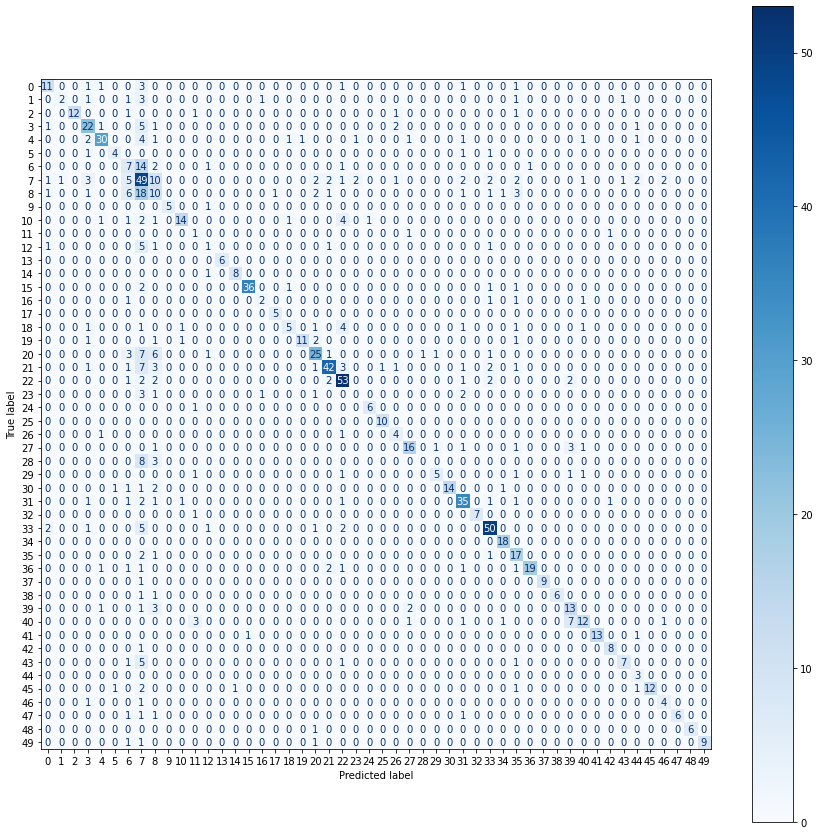

Normalized confusion matrix


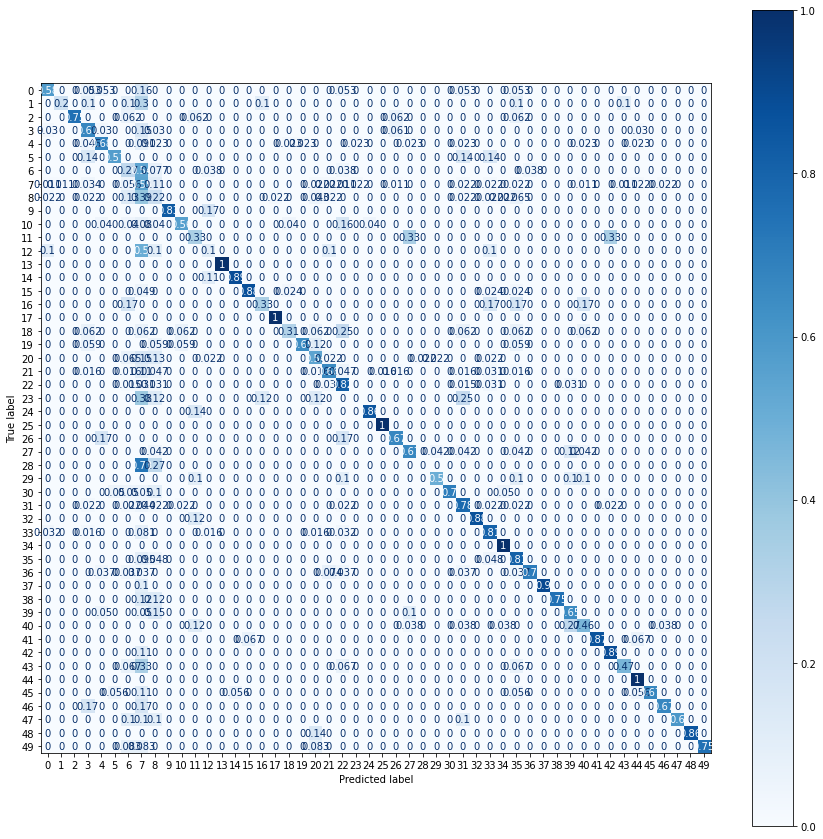

In [ ]:
gs = RandomForestClassifier()

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

np.set_printoptions(precision=2)

#plt.figure(figsize=(20, 20))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
cpt = 1 
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(15, 15))
    metrics.plot_confusion_matrix(gs, X_test_scaled, y_test, \
                                  # display_labels=class_names, 
                                  cmap=plt.cm.Blues, \
                                  normalize=normalize, ax=ax)
    #ax_.set_title(title)

    print(title)
    #print(disp.confusion_matrix)
    plt.show()
    cpt += 1 

# LDA

In [ ]:
#instantiate CountVectorizer() 
cv=CountVectorizer() 
 
# this steps generates word counts for the words in your docs 
TF_Title=cv.fit_transform(train_1T.Title)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 50

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(TF_Title)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=50, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tfidf.columns[:-1], no_top_words)

Topic 0:
tripl ror printf statu newcom integr rule megabyt tail cart
Topic 1:
getrespons shadow fnc comprehens proper protect raw multipli fieldnam namespac
Topic 2:
euler compareto transit dst arraylist mozilla isv updat loop stringparam
Topic 3:
watch collaps system freelanc seri grandpar significantli recommend optimis winform
Topic 4:
verticalalign stringbuild procedur verbos input cocoa round look dealloc erb
Topic 5:
mercuri roll cl default smoothli mixin multipl other roundup eula
Topic 6:
android worker tamper placeholderpagetitleintitlearea collect signific miss version back somefunc
Topic 7:
name asp multi resourc applic eval vb continu valueof action
Topic 8:
teach ifoo reload commun dimension drive initialzi enablecontrol layer trigger
Topic 9:
storabl isv array chanukah besid perform overkil host nativ concret
Topic 10:
jre execut urg overwrit dialogprefer cr usag dialog preprocessor scrap
Topic 11:
screenshot javascript cheat riddl urg squash onto hundr firebug ispostback